## Exercício 10 - Modelos de Classificação:

O __objetivo__ aqui será construir um algoritmo que faça a __predição se um dígito é par ou ímpar.__

Para isso, faça um tratamento inicial na variável target.

Use a __AUC__ como métrica de performance.

Teste diferentes versões do KNN-Classifier, bem como a regressão logística. 

Use a __metodologia de validação cruzada__, implementando manualmente a AUC, conforme feito nas aulas.

Plote as __curvas ROC__ dos algoritmos.

In [3]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target'].astype(float)

X.shape, y.shape


((70000, 784), (70000,))

In [4]:
# Separando o dataset

Xtrain, Xtest, ytrain, ytest = X[:55000], X[55000:], y[:55000], y[55000:]


In [5]:
# Setando a condição True para a validação do números pares

ytrain_par = np.where(ytrain % 2 == 0, 1, 0)
ytest_par = np.where(ytest % 2 == 0, 1, 0)

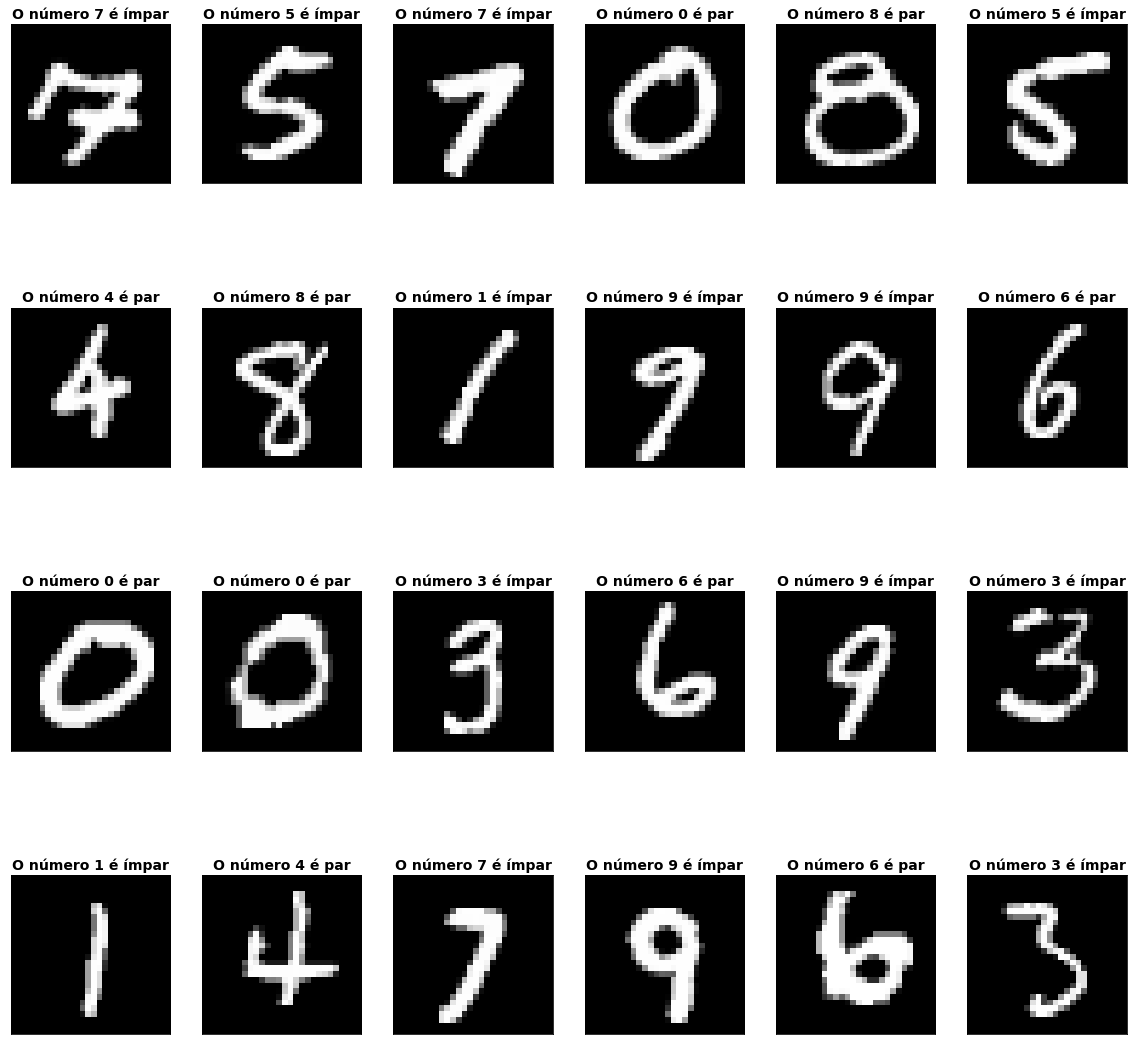

In [6]:
# Pegando 24 digitos aleatórios e seus targets verdadeiros

random_idx = np.random.randint(0, Xtrain.shape[0], size=24)

plt.figure(figsize=[20,20])

for i in range(len(random_idx)):
    idx_i = random_idx[i]
    
    xval = Xtrain.values[idx_i, :].reshape(28,28)
    yval = ytrain[idx_i]
    yval_par = ytrain_par[idx_i]

    plt.subplot(4,6, i+1)
    plt.imshow(xval, cmap=plt.cm.Greys_r)
    plt.xticks([])
    plt.yticks([])

    if yval_par:
        result = "par"
    else:
        result = "ímpar"

    plt.title('O número ' + str(int(yval)) + ' é '+ str(result), fontsize=14, fontweight='bold')



In [13]:
# Regressão Logística

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

def classificador_logistico(X_train, y_train, print_info=True):
    logreg = LogisticRegression()   

    logreg.fit(X_train, y_train)

    ytrain_pred = logreg.predict(Xtrain)
    ytrain_prob = logreg.predict_proba(Xtrain) 

    if print_info:
        print(f"Inrtercept: {logreg.intercept_}")
        print(f"Coef size: {logreg.coef_.size}")
        print(f'A precisão da regressão logística é de {accuracy_score(ytrain_par, ytrain_pred).round(3)} %')
        print(f"Predições: {ytrain_pred}")

    return logreg, ytrain_pred, ytrain_prob

logreg, ytrain_pred, ytrain_prob =  classificador_logistico(Xtrain, ytrain_par)
    

Inrtercept: [-0.00096028]
Coef size: 784
A precisão da regressão logística é de 0.899 %
Predições: [0 1 1 ... 1 1 1]


In [26]:
from sklearn.model_selection import cross_val_score

logreg_cross_score = cross_val_score(logreg, Xtrain, ytrain_par, cv=3, scoring='accuracy')

print(f"O score de validação cruzada do modelo é: {logreg_cross_score}, com média {logreg_cross_score.mean().round(3)}")

O score de validação cruzada do modelo é: [0.89004036 0.89603447 0.89368898], com média 0.893


In [38]:
def cross_scores(classifier, Xtrain, ytrain, cv=3, scoring='accuracy'):
  from sklearn.model_selection import cross_val_score
  cross_score = cross_val_score(classifier, Xtrain, ytrain, cv=cv, scoring=scoring)
  print(f"O score de validação cruzada do modelo é: {cross_score}, com média {cross_score.mean().round(3)}")

In [15]:
from sklearn.model_selection import cross_val_predict

ytrain_scores = cross_val_predict(logreg, Xtrain, ytrain_par, cv=3, method='decision_function')
ytrain_scores

array([-6.44456716,  2.26379557,  0.64755472, ...,  5.11758212,
        0.33133532,  4.80132863])

In [16]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(ytrain_par, ytrain_scores)


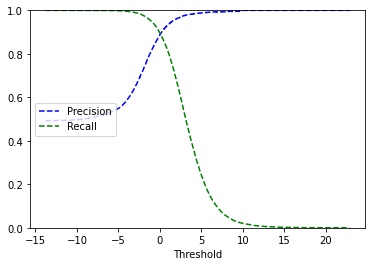

In [17]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()



In [18]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(ytrain_par, ytrain_scores)

In [20]:
from sklearn.metrics import roc_auc_score

print(f"O modelo de regressão logística tem {roc_auc_score(ytrain_par, ytrain_scores).round(3)*100} % de precisão.")

O modelo de regressão logística tem 95.6 % de precisão.


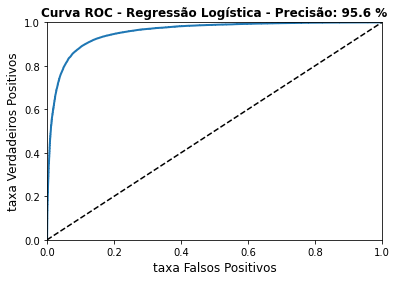

In [21]:
def plot_roc_curve(fpr, tpr, label=None, title=None):
    #plt.figure(figsize=[10,10])
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('taxa Falsos Positivos', fontsize=12)
    plt.ylabel('taxa Verdadeiros Positivos', fontsize=12)
    plt.title(title, fontweight='bold', fontsize=12)  

plot_roc_curve(fpr, tpr, title=f'Curva ROC - Regressão Logística - Precisão: {roc_auc_score(ytrain_par, ytrain_scores).round(3)*100} %')
plt.show()

In [27]:
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
ytrain_probas_forest = cross_val_predict(forest_clf, Xtrain, ytrain_par, cv=3, method='predict_proba')

In [28]:
ytrain_scores_forest = ytrain_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(ytrain_par, ytrain_scores_forest)

In [29]:
forest_score = roc_auc_score(ytrain_par, ytrain_scores_forest)
print(f"O modelo classificador floresta aleatória tem {forest_score.round(3)*100} % de precisão.")

O modelo classificador floresta aleatória tem 99.7 % de precisão.


In [39]:
cross_scores(forest_clf, Xtrain, ytrain_par)

O score de validação cruzada do modelo é: [0.97485546 0.97278132 0.9731086 ], com média 0.974


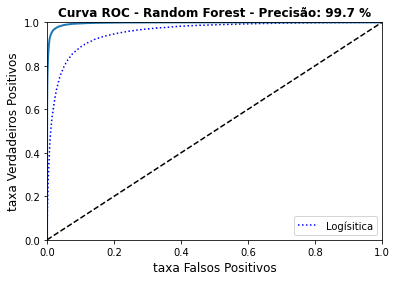

In [31]:
plt.plot(fpr, tpr, 'b:', label='Logísitica')
plot_roc_curve(fpr_forest, tpr_forest, title=f'Curva ROC - Random Forest - Precisão: {roc_auc_score(ytrain_par, ytrain_scores_forest).round(3)*100} %')
plt.legend(loc='lower right')
plt.show()

In [32]:
# KNeighbors

from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(Xtrain, ytrain_par)

KNeighborsClassifier()

In [60]:
ytrain_probas_knn = cross_val_predict(knn_clf, Xtrain, ytrain_par, cv=3, method='predict_proba')
ytrain_scores_knn = ytrain_probas_knn[:, 1]

knn_score = roc_auc_score(ytrain_par, ytrain_scores_knn)
print(f"O modelo K-Neighbors tem {knn_score.round(3)*100} % de precisão.")

O modelo K-Neighbors tem 99.3 % de precisão.


In [40]:
cross_scores(knn_clf, Xtrain, ytrain_par)

O score de validação cruzada do modelo é: [0.98036435 0.98216331 0.97954508], com média 0.981


In [50]:
digit = 31568

some_digit = X.values[digit]
print(y[digit])

knn_clf.predict(some_digit.reshape(1, -1))

6.0


array([1])

In [53]:
knn_clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [54]:
from sklearn.model_selection import GridSearchCV

grid_params = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhatthan', 'minkowski']
}

gs = GridSearchCV(
    knn_clf,
    grid_params,
    verbose = 1,
    cv = 3,
    n_jobs = -1
)

gs.results = gs.fit(Xtrain, ytrain_par)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [55]:
gs.best_params_

{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}

In [56]:
knn_clf = KNeighborsClassifier(n_neighbors=3, metric='euclidean', weights='uniform')

In [57]:
ytrain_probas_knn = cross_val_predict(knn_clf, Xtrain, ytrain_par, cv=3, method='predict_proba')
ytrain_scores_knn = ytrain_probas_knn[:, 1]

In [59]:
knn_score = roc_auc_score(ytrain_par, ytrain_scores_knn)
print(f"O modelo K-Neighbors tem {knn_score.round(3)*100} % de precisão.")

O modelo K-Neighbors tem 99.3 % de precisão.


In [62]:
cross_scores(knn_clf, Xtrain, ytrain_par)

O score de validação cruzada do modelo é: [0.98172794 0.98243604 0.98030873], com média 0.981


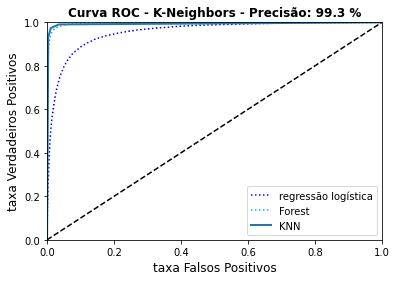

In [63]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(ytrain_par, ytrain_scores_knn)

plt.plot(fpr, tpr, 'b:', label='regressão logística')
plt.plot(fpr_forest, tpr_forest, 'c:', label='Forest')
plot_roc_curve(fpr_knn, tpr_knn, title=f'Curva ROC - K-Neighbors - Precisão: {roc_auc_score(ytrain_par, ytrain_scores_knn).round(3)*100} %', label='KNN')
plt.legend(loc='lower right')
plt.show()

In [64]:
# Avaliando o sistema no conjunto de testes

knn_clf.fit(Xtest, ytest_par)
knn_predict = knn_clf.predict(Xtest)

In [65]:
ytest_probas_knn = cross_val_predict(knn_clf, Xtest, ytest_par, cv=3, method='predict_proba')

ytest_scores_knn = ytest_probas_knn[:, 1]

final_model = gs.best_estimator_

final_predictions = final_model.predict(Xtest)
final_score = roc_auc_score(ytest_par, ytest_scores_knn)

In [70]:
final_score.round(3)*100

98.9

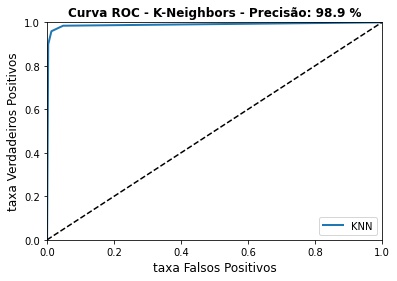

In [66]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(ytest_par, ytest_scores_knn)

plot_roc_curve(fpr_knn, tpr_knn, title=f'Curva ROC - K-Neighbors - Precisão: {roc_auc_score(ytest_par, ytest_scores_knn).round(3)*100} %', label='KNN')
plt.legend(loc='lower right')
plt.show()

#Conclusões:
##Escolhido o modelo KNeighbors devido ao mesmo apresentar a maior taxa de precisão utilizando a metodologia de validação cruzada.


Digite um número de 0 a 69999: 0
O número associado a esse dígito é 5.0, e segundo o modelo ele é impar



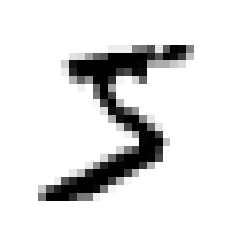

In [94]:
digit = int(input(f'Digite um número de 0 a {X.shape[0]-1}: '))

some_digit = X.values[digit]
predict_par = final_model.predict(some_digit.reshape(1, -1))

message = ""

if predict_par:
  message = 'par'
else:
  message = 'impar'

print(f'O número associado a esse dígito é {y[digit]}, e segundo o modelo ele é {message}')
print()

plt.imshow(some_digit.reshape(28, 28), cmap=plt.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()